## Libraries

In [1]:
!pip install keras-core

In [2]:
!pip install tf-models-official==2.16.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 36.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 352.1/352.1 kB 23.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 427.8/427.8 kB 29.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.0/104.0 kB 7.7 MB/s eta 0:00:00
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16161 sha256=a53313cff16c9f56b53fc1dfc44c6b5a8d4433ddfe7156dcfb854da2ae240061
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval


In [3]:
%matplotlib inline

In [4]:
import warnings
warnings.filterwarnings('ignore')
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [5]:
import os
import shutil
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


import tensorflow as tf
import tensorflow_models as tfm
import tensorflow_hub as hub
import tensorflow_text as text
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Embedding, Input, Dense, Dropout, Reshape, Concatenate
from keras.layers import LSTM, Flatten, Dropout, MultiHeadAttention, Bidirectional, Layer
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback
import time

In [6]:
print(tf.__version__)

2.16.1


In [7]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
else:
    print('Using CPU')

Using GPU


In [8]:
np.random.seed(42)

In [9]:
%matplotlib inline

## 0. Context

Here, we will use transformer models, attention layers, bidirectional layers, and the rest of the algorithms studied so far to build and train a grammatical paraphrasing classifier. Paraphrasing refers to using different expressions or words to express the same thing. To clarify this point, let's look at a paraphrasing example:

I'm going to go from Madrid to Barcelona.
I'm going to travel to Barcelona from Madrid.

However, it can happen that using the same words, the meaning is completely different. Here is an example of non-paraphrase where the same words are used but the meaning changes radically:

I'm going to travel from Vitoria to Madrid.
I'm going to travel from Madrid to Vitoria.

The neural architecture that we design, train, and test must be able to distinguish whether two sentences have the same meaning or not.

Although it may seem like a game, the complexity and scientific challenge posed is very high and was completely out of reach until just a decade ago. On the one hand, it is necessary to have a high degree of knowledge of the lexicon of the language, and on the other hand, it is necessary to have a deep understanding of how context, grammar, and long-distance relationships between words generate the abstract meaning of a sentence. The applications of an architecture capable of doing this are many, such as grammatical correction systems, text simplification systems, summary generation systems, etc.

Here, the PAWS (Paraphrase Adversaries from Word Scrambling) database has been chosen, specifically the PAW-Wiki version. The motivation of this database is to provide an existing paraphrase identification dataset to train specific models. It consists of 49,401 training paraphrases, 8,000 for development, and 8,000 for testing.

## 1. Data loading, preprocessing, visualization

To prepare the data, I will:

1. Download the paws_wiki dataset using tensorflow_datasets. (https://www.tensorflow.org/datasets/catalog/paws_wiki). 
2. Divide it into train, validation, and test sets.
3. Process the objects obtained with tensorflow_datasets appropriately and generate: train_sentence1, train_sentence2, train_labels, val_sentence1, val_sentence2, val_labels, test_sentence1, test_sentence2, and test_labels. These new variables should be lists.
4. Show the first 3 elements of each list. When displaying them, do it in a suitable way, such as in a table or with another method, but something like: phrase_train_sentence1, phrase1_train_sentence 2, train_label
5. Show a table with the dimensions of each object.
6. Show a histogram of the size of the sentences (in the number of words) of train_sentence1.
7. Make sure to include a title and the names of the axes.

In [10]:
# Load dataset
paws_wiki = tfds.load("paws_wiki")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/49401 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/paws_wiki/labeled_final_tokenized/incomplete.MUTN1T_1.1.0/paws_wiki-train.…

Generating validation examples...:   0%|          | 0/8000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/paws_wiki/labeled_final_tokenized/incomplete.MUTN1T_1.1.0/paws_wiki-valida…

Generating test examples...:   0%|          | 0/8000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/paws_wiki/labeled_final_tokenized/incomplete.MUTN1T_1.1.0/paws_wiki-test.t…

Dataset paws_wiki downloaded and prepared to /root/tensorflow_datasets/paws_wiki/labeled_final_tokenized/1.1.0. Subsequent calls will reuse this data.


In [11]:
# Separate in train, val and test
paws_wiki_train = paws_wiki['train']
paws_wiki_val = paws_wiki['validation']
paws_wiki_test = paws_wiki['test']

In [12]:
# Separate training dataset
train_sentence1 = []
train_sentence2 = []
train_labels = []

# Decode phrases and add to relevant variables
for element in paws_wiki_train:
    train_sentence1.append(element['sentence1'].numpy().decode('utf-8'))
    train_sentence2.append(element['sentence2'].numpy().decode('utf-8'))
    train_labels.append(element['label'].numpy())
    
# Show that variables are lists
print('Variable type train_sentence1: '+str(type(train_sentence1)))
print('Variable type train_sentence2: '+str(type(train_sentence2)))
print('Variable type label: '+str(type(train_labels)))

Variable type train_sentence1: <class 'list'>
Variable type train_sentence2: <class 'list'>
Variable type label: <class 'list'>


In [13]:
# Separate validation dataset
val_sentence1 = []
val_sentence2 = []
val_labels = []

# Decode phrases and add to relevant variables
for element in paws_wiki_val:
    val_sentence1.append(element['sentence1'].numpy().decode('utf-8'))
    val_sentence2.append(element['sentence2'].numpy().decode('utf-8'))
    val_labels.append(element['label'].numpy())

# Show that variables are lists
print('Variable type val_sentence1: '+str(type(val_sentence1)))
print('Variable type val_sentence2: '+str(type(val_sentence2)))
print('Variable type label: '+str(type(val_labels)))

Variable type val_sentence1: <class 'list'>
Variable type val_sentence2: <class 'list'>
Variable type label: <class 'list'>


In [14]:
# Separate test dataset
test_sentence1 = []
test_sentence2 = []
test_labels = []

for element in paws_wiki_test:
    test_sentence1.append(element['sentence1'].numpy().decode('utf-8'))
    test_sentence2.append(element['sentence2'].numpy().decode('utf-8'))
    test_labels.append(element['label'].numpy())
    
print('Variable type test_sentence1: '+str(type(test_sentence1)))
print('Variable type test_sentence2: '+str(type(test_sentence2)))
print('Variable type label: '+str(type(test_labels)))

Variable type test_sentence1: <class 'list'>
Variable type test_sentence2: <class 'list'>
Variable type label: <class 'list'>


In [15]:
pd.set_option('display.max_colwidth', None)

# Show first 3 elements of training set
train_set = [train_sentence1, train_sentence2, train_labels]

df_train = pd.DataFrame(index=range(0,3), columns=['train_sentence1', 'train_sentence2', 'train_label'])

for el in range(0,3):
    for set in range(0,3):
        if set <2 :
            df_train.loc[el, df_train.columns[set]] = train_set[set][el]
        else:
            df_train.loc[el, df_train.columns[set]] = train_set[set][el]

df_train.head()

,train_sentence1,train_sentence2,train_label
0,"Hugo Käch died on December 31 , 2003 in Schaffhausen near Flurlingen , Germany .",Hugo Käch died on 31 December 2003 in Flurlingen near Schaffhausen .,0
1,"In 2013 Peter married Anna Barattin while Julia is married to Nicholas Furiuele , both are members of the band Shantih Shantih .","Peter Anna Barattin married in 2013 while Julia was married to Nicholas Furiuele , both of whom are members of the band Shantih Shantih .",1
2,"The recent Sierra Leone Civil War was secular in nature featuring members of Tribal , Muslim , and Christian faiths fighting on both sides of the conflict .","The recent civil war in Sierra Leone was secular in nature , with members of Christian , Muslim , and tribal faith fighting on both sides of the conflict .",1


In [16]:
# Show first 3 elements of validation set
val_set = [val_sentence1, val_sentence2, val_labels]

df_val = pd.DataFrame(index=range(0,3), columns=['val_sentence1', 'val_sentence2', 'val_label'])

for el in range(0,3):
    for set in range(0,3):
        if set <2 :
            df_val.loc[el, df_val.columns[set]] = val_set[set][el]
        else:
            df_val.loc[el, df_val.columns[set]] = val_set[set][el]

df_val.head()

,val_sentence1,val_sentence2,val_label
0,The plant may have some medical properties and has been used in traditional medicine in South Asia and in traditional Chinese medicine .,The plant can have some medical properties and has been used in traditional Chinese medicine in South Asia and traditional medicine .,0
1,"This was recorded in two separate inscriptions from his corpse hill Medinet Habu , which are physically long and somewhat different from one another .","This was recorded in two long inscriptions from his body horde Medinet Habu , which are physically separate and somewhat different from one another .",0
2,"Malcolm Fraser , who had defeated Whitlam in a landslide at the federal election in December 1975 , offered Egerton the knighthood for serving the trade union movement .","Whitlam , who had defeated Malcolm Fraser in a landslide at the federal election in December 1975 , offered Egerton the knighthood for serving the trade union movement .",0


In [27]:
# Show first 3 elements of test set
test_set = [test_sentence1, test_sentence2, test_labels]

df_test = pd.DataFrame(index=range(0,3), columns=['test_sentence1', 'test_sentence2', 'test_label'])

for el in range(0,3):
    for set in range(0,3):
        if set <2 :
            df_test.loc[el, df_test.columns[set]] = test_set[set][el]
        else:
            df_test.loc[el, df_test.columns[set]] = test_set[set][el]

df_test.head()

,test_sentence1,test_sentence2,test_label
0,"The NRA has referred to the NAGR leader , Dudley Brown , as '' Al Sharpton of the gun movement `` .",The NRA has referred to the NAGR - leader Al Sharpton as '' the Dudley Brown of the gun movement `` .,0
1,The layout of Belmont is similar to that of Twin Pines park and other parks in Davey Glen Park .,The Belmont layout is similar to that of Twin Pines Park and other parks in Davey Glen Park .,1
2,"Road access to Island Harbour is via Mill Lane , which connects to North Fairlee Road ( A3054 ) .","The access to North Fairlee Road is via Mill Lane , which connects to the Island Harbour ( A3054 ) .",0


In [28]:
# Show number of elements in each list
objects = [train_sentence1, train_sentence2, train_labels, val_sentence1, val_sentence2, val_labels, test_sentence1, test_sentence2, test_labels]
objects_names = ["train_sentence1", "train_sentence2", "train_labels", "val_sentence1", "val_sentence2", "val_labels", "test_sentence1", "test_sentence2", "test_labels"]

for el in range(len(objects)):
    print("Size of "+objects_names[el]+": "+str(len(objects[el])))

Size of train_sentence1: 49401
Size of train_sentence2: 49401
Size of train_labels: 49401
Size of val_sentence1: 8000
Size of val_sentence2: 8000
Size of val_labels: 8000
Size of test_sentence1: 8000
Size of test_sentence2: 8000
Size of test_labels: 8000


Before showing the histogram with the number of words in each phrase of train_sentence1, I'm going to remove characters that are not spaces, letters, or numbers. The reason is that to count the number of words in each phrase I'm going to use .split(). If I do it without removing characters that are not spaces, letters, or numbers, the split will separate those characters and they will be counted as words later. Let's see an example of a phrase before removing those characters:

In [29]:
# Show a phrase before removing characters that are not spaces, letters, or numbers
train_sentence1[0]

'Hugo Käch died on December 31 , 2003 in Schaffhausen near Flurlingen , Germany .'

In [30]:
# For each sentence in train_sentence1 get the text
train_sentence1_words = []

for el in range(len(train_sentence1)):
    train_sentence1_words.append(train_sentence1[el])

In [31]:
# Eliminate anything that is not numbres, leters or spaces
train_sentence1_words_clean = []

for el in range(len(train_sentence1_words)):
    train_sentence1_words_clean.append(re.sub(r"[^a-zA-Z0-9_ ]","",train_sentence1_words[el]))

In [32]:
# Count number of words in each sentence, add to a count list
train_sentence1_words_count = []

for el in range(len(train_sentence1_words_clean)):
    train_sentence1_words_count.append(len(train_sentence1_words_clean[el].split()))

In [33]:
# Show a phrase after removing characters that are not spaces, letters, or numbers
train_sentence1_words_clean[0]

'Hugo Kch died on December 31  2003 in Schaffhausen near Flurlingen  Germany '

In [34]:
# Create a dataframe from the list with the number of words per sentence
df_words_train_sentence1 = pd.DataFrame(data=train_sentence1_words_count, index=range(len(train_sentence1_words_count)), columns=['Number_words_train_sentence1'])
df_words_train_sentence1

,Number_words_train_sentence1
0,12
1,21
2,25
3,21
4,16
...,...
49396,19
49397,11
49398,17
49399,22


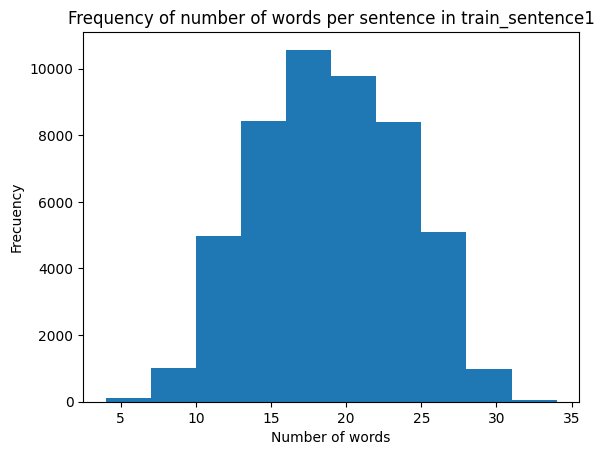

In [35]:
# Show number of words per sentence in train_sentence1
plt.hist(df_words_train_sentence1)
plt.title("Frequency of number of words per sentence in train_sentence1")
plt.xlabel("Number of words")
plt.ylabel("Frecuency")
plt.show()

The frequency of occurrence depends on the size of the bin, but we see that, for the default size of matplotlib.plt, we have about 15-20 words per sentence.

## 1.1. Label processing and tokenization

We will now use the `tf.keras.preprocessing.text.Tokenizer` class from TensorFlow to process the sentences and convert them into numbers, limiting the number of distinct words (vocabulary) to 5,000 words, and using the option oov_token="-OOV-" for out-of-vocabulary words.

In [36]:
# Instantiate and train the tokenizer using train_sentence1 and train_sentence2
tokenizer = tf.keras.preprocessing.text.Tokenizer(
    num_words=5000,
    oov_token="-OOV-")

tokenizer.fit_on_texts(train_sentence1+train_sentence2)

In [37]:
# Show one sentence before tokenizing
train_sentence1[1]

'In 2013 Peter married Anna Barattin while Julia is married to Nicholas Furiuele , both are members of the band Shantih Shantih .'

In [38]:
# Tokenize the sentence
token_example = tokenizer.texts_to_sequences(train_sentence1[1].split())
print(token_example)

[[3], [229], [293], [54], [1311], [1], [92], [2618], [7], [54], [9], [1571], [1], [], [245], [21], [275], [5], [2], [244], [3958], [3958], []]


In [39]:
# Detokenize the sentence
print(tokenizer.sequences_to_texts(token_example))

['in', '2013', 'peter', 'married', 'anna', '-OOV-', 'while', 'julia', 'is', 'married', 'to', 'nicholas', '-OOV-', '', 'both', 'are', 'members', 'of', 'the', 'band', 'shantih', 'shantih', '']


In [40]:
# Show some elements of the dictionary
list(tokenizer.__dict__["word_index"])[0:20]

['-OOV-',
 'the',
 'in',
 'and',
 'of',
 'a',
 'is',
 'was',
 'to',
 'by',
 'on',
 'with',
 "''",
 'for',
 'as',
 'he',
 'from',
 'it',
 'his',
 'at']

A tokenizer is a tool that splits texts into smaller units and assigns numerical values to each of those units. It does this by creating a base vocabulary with a specified number of words (this is the role of the `num_words` parameter). The tokenizer is trained on a text, which serves as the training data, so that it selects the words from that text to form the vocabulary. Once trained, the tokenizer can tokenize a text (as demonstrated in the example from the last three cells) and decode it, since each word in the vocabulary has an associated numerical value. Besides the number of words, other important tokenizer parameters include:

`filters`: In natural language texts, there are characters with little or no semantic value. When instantiating the tokenizer, filters are used to remove these characters.  
`lower`: The tokenizer can convert all letters to lowercase to ensure, for instance, that words at the beginning of a sentence (starting with an uppercase letter) don't get a different numerical value from the same word in the middle of the sentence, written entirely in lowercase. By default, lower is set to True.  
`split`: Similar to the split() method of a regular Python string. It specifies which character will be used to split sentences into words. By default, it's a space.  
`char_level`: If set to False (default), sentences are split into words. If set to True, they are split into characters. In our case, we leave it at the default.  
`oov_token`: The token value for words not present in the dictionary. In our case, it's "-OOV-".  
`analyzer`: Processes the text and converts it into a stream of tokens. In our case, this is not used.

## 1.2. Preparing data for training

Let’s prepare our data for training by:

1. Tokenizing `train_sentence1`, `train_sentence2`, `val_sentence1`, `val_sentence2`, `test_sentence1`, and `test_sentence2`.
2. Calculating the length of the longest sentence in train_sentence1 and train_sentence2.
3. Using the function `preprocessing.sequence.pad_sequences` with zeros so that all tokenized sentences have the same length, equal to the length of the longest sentence.
4. Converting the variables `Y_train`, `y_val`, and `y_test` into `numpy.arrays`.

In [41]:
# Tokenize sets
tokenized_train_sentence1 = tokenizer.texts_to_sequences(train_sentence1)
tokenized_train_sentence2 = tokenizer.texts_to_sequences(train_sentence2)

tokenized_val_sentence1 = tokenizer.texts_to_sequences(val_sentence1)
tokenized_val_sentence2 = tokenizer.texts_to_sequences(val_sentence2)

tokenized_test_sentence1 = tokenizer.texts_to_sequences(test_sentence1)
tokenized_test_sentence2 = tokenizer.texts_to_sequences(test_sentence2)

In [42]:
# Calculate max length of train_sentence1
length_tokenized_train_sentence1 = []

for el in range(len(tokenized_train_sentence1)):
    length_tokenized_train_sentence1.append(len(tokenized_train_sentence1[el]))

longest_tokenized_train_sentence1 = max(length_tokenized_train_sentence1)

print("The max sentence length of tokenized_train_sentence1 is: "+str(longest_tokenized_train_sentence1))

The max sentence length of tokenized_train_sentence1 is: 40


In [43]:
# Calculate max length of train_sentence2
length_tokenized_train_sentence2 = []

for el in range(len(tokenized_train_sentence2)):
    length_tokenized_train_sentence2.append(len(tokenized_train_sentence2[el]))
    
longest_tokenized_train_sentence2 = max(length_tokenized_train_sentence2)
    
print("The max sentence length of tokenized_train_sentence2 is: "+str(longest_tokenized_train_sentence2))

The max sentence length of tokenized_train_sentence2 is: 40


In [44]:
longest_sentence = max(longest_tokenized_train_sentence1, longest_tokenized_train_sentence2)

In [45]:
# Add padding up to the longest sentence lenght
X_train1 = pad_sequences(
    tokenized_train_sentence1,
    maxlen=longest_sentence)

X_train2 = pad_sequences(
    tokenized_train_sentence2,
    maxlen=longest_sentence)

X_val1 = pad_sequences(
    tokenized_val_sentence1,
    maxlen=longest_sentence)

X_val2 = pad_sequences(
    tokenized_val_sentence2,
    maxlen=longest_sentence)

X_test1 = pad_sequences(
    tokenized_test_sentence1,
    maxlen=longest_sentence)

X_test2 = pad_sequences(
    tokenized_test_sentence2,
    maxlen=longest_sentence)

In [46]:
# Convert labels to numpy array
y_train = np.array(train_labels)
y_val = np.array(val_labels)
y_test = np.array(test_labels)

In [47]:
# Show dimensions of sets
sets = [X_train1, X_train2, X_val1, X_val2, X_test1, X_test2, y_train, y_val, y_test]
names_sets = ["X_train1", "X_train2", "X_val1", "X_val2", "X_test1", "X_test2", "y_train", "y_val", "y_test"]

print("Sets dimensions")

for el in range(len(sets)):
    print(names_sets[el]+": "+str(sets[el].shape))

Sets dimensions
X_train1: (49401, 40)
X_train2: (49401, 40)
X_val1: (8000, 40)
X_val2: (8000, 40)
X_test1: (8000, 40)
X_test2: (8000, 40)
y_train: (49401,)
y_val: (8000,)
y_test: (8000,)


## 2. Aleatory base model

We are going to build an architecture that will contain all the typical elements of a transformer architecture. The great advantage of architectures with attention elements is their ability to scale when trained with a large amount of data. In this case, given that the computational capacity is limited, the amount of data we will work with will be small, so it is very likely that the architecture will overfit very soon.

Before moving on to the transformers, and given this likely tendency to overfitting we will see in our NNs, let's first evaluate the data we have and generate an aleatory estimation of what accuracy we might get by randomly assigning sentences to categories. Let's see if the datasets are balanced in terms of number of labels per class.

In [48]:
train_unique, train_counts = np.unique(y_train, return_counts=True)

print("Proportion of labels 0 in y_train: "+str(round(
    train_counts[0]/(train_counts[0]+train_counts[1]),2)))

print("Proportion of labels 1 in y_train: "+str(round(
    train_counts[1]/(train_counts[0]+train_counts[1]),2)))

Proportion of labels 0 in y_train: 0.56
Proportion of labels 1 in y_train: 0.44


In [49]:
val_unique, val_counts = np.unique(y_val, return_counts=True)

print("Proportion of labels 0 in y_val: "+str(round(
    val_counts[0]/(val_counts[0]+val_counts[1]),2)))

print("Proportion of labels 1 in y_val: "+str(round(
    val_counts[1]/(val_counts[0]+val_counts[1]),2)))

Proportion of labels 0 in y_val: 0.56
Proportion of labels 1 in y_val: 0.44


In [50]:
test_unique, test_counts = np.unique(y_test, return_counts=True)

print("Proportion of labels 0 in y_test: "+str(round(
    test_counts[0]/(test_counts[0]+test_counts[1]),2)))

print("Proportion of labels 1 in y_test: "+str(round(
    test_counts[1]/(test_counts[0]+test_counts[1]),2)))

Proportion of labels 0 in y_test: 0.56
Proportion of labels 1 in y_test: 0.44


We see that the datasets are balanced in terms of label proportion.

**What would be the accuracy of a random model conditioned on the fact that we know the proportion of data for each class in the training set?**  
  
We can establish two scenarios:  
1. If we trained a random model that only learned that there are more labels of class 0 and therefore only returned 0 as output, we would expect an accuracy of 0.56  
2. If we trained a model that learned that there is a 56% of labels of class 0 and a 44% of labels of class 1, then the value of accuracy would change. We can calculate the value of accuracy using the proportions of labels of each class and the proportions of actual labels. The value of accuracy is calculated as TP + TN / TP + FP + TN + FN. That is, TP + TN divided by the total number of instances. We can calculate what the value of TP and TN is. For TN (that is, that it is label 0 and the random model says that it is label 0 we have that there is a 56% of instances that are 0 and a 56% of times that the model gives us 0. If we multiply 0.56 * 0.56 we get 0.3136. We do the same for TP (0.44 * 0.44) and it gives us 0.1936. Therefore, the sum is the accuracy of the random model that knows the proportions of the classes and decides accordingly: 0.5072

## 3. Base model with a multi-head attention layer

Let's build the base of the architecture. To do this:

1. The model will have two inputs. These inputs are the phrases we want to compare and decide if they are paraphrases.
2. Each of them will be the input of an Embedding layer with an output_dim of 20 and the rest of the dimensions adequate.
3. Then they will be fed into a MultiHeadAttention layer of 2 heads and whose key_dim is the output_dim of the previous layer
4. Then it goes through a Flatten layer.
5. Then both vectors are concatenated.
6. Finally, we will add a last classification layer of one neuron and sigmoid activation

In [51]:
# Network definition
input1 = tf.keras.Input(shape=(40,))
input2 = tf.keras.Input(shape=(40,))

embedding1 = tf.keras.layers.Embedding(input_dim=5000, output_dim=20, input_length=40, mask_zero=True)(input1)
embedding2 = tf.keras.layers.Embedding(input_dim=5000, output_dim=20, input_length=40, mask_zero=True)(input2)

attention1 = tf.keras.layers.MultiHeadAttention(num_heads=2, key_dim=20)(embedding1, embedding1)
attention2 = tf.keras.layers.MultiHeadAttention(num_heads=2, key_dim=20)(embedding2, embedding2)

flatten1 = tf.keras.layers.Flatten()(attention1)
flatten2 = tf.keras.layers.Flatten()(attention2)

concatenate = tf.keras.layers.Concatenate()([flatten1, flatten2])

output = tf.keras.layers.Dense(1, activation="sigmoid")(concatenate)

model_base = Model(inputs = [input1, input2], outputs = output)

In [52]:
# Compile
model_base.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.BinaryCrossentropy(), metrics=["accuracy"])
model_base.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 40)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 40)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 40, 20)    │    100,000 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 40)        │          0 │ input_layer[0][0] │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 40, 20)    │    100,000 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_1         │ (None, 40)        │          0 │ input_layer_1[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 40, 20)    │      3,340 │ embedding[0][0],  │
│ (MultiHeadAttentio… │                   │            │ embedding[0][0],  │
│                     │                   │            │ not_equal[0][0],  │
│                     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 40, 20)    │      3,340 │ embedding_1[0][0… │
│ (MultiHeadAttentio… │                   │            │ embedding_1[0][0… │
│                     │                   │            │ not_equal_1[0][0… │
│                     │                   │            │ not_equal_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 800)       │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 800)       │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 1600)      │          0 │ flatten[0][0],    │
│ (Concatenate)       │                   │            │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1)         │      1,601 │ concatenate[0][0] │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 208,281 (813.60 KB)

 Trainable params: 208,281 (813.60 KB)

 Non-trainable params: 0 (0.00 B)

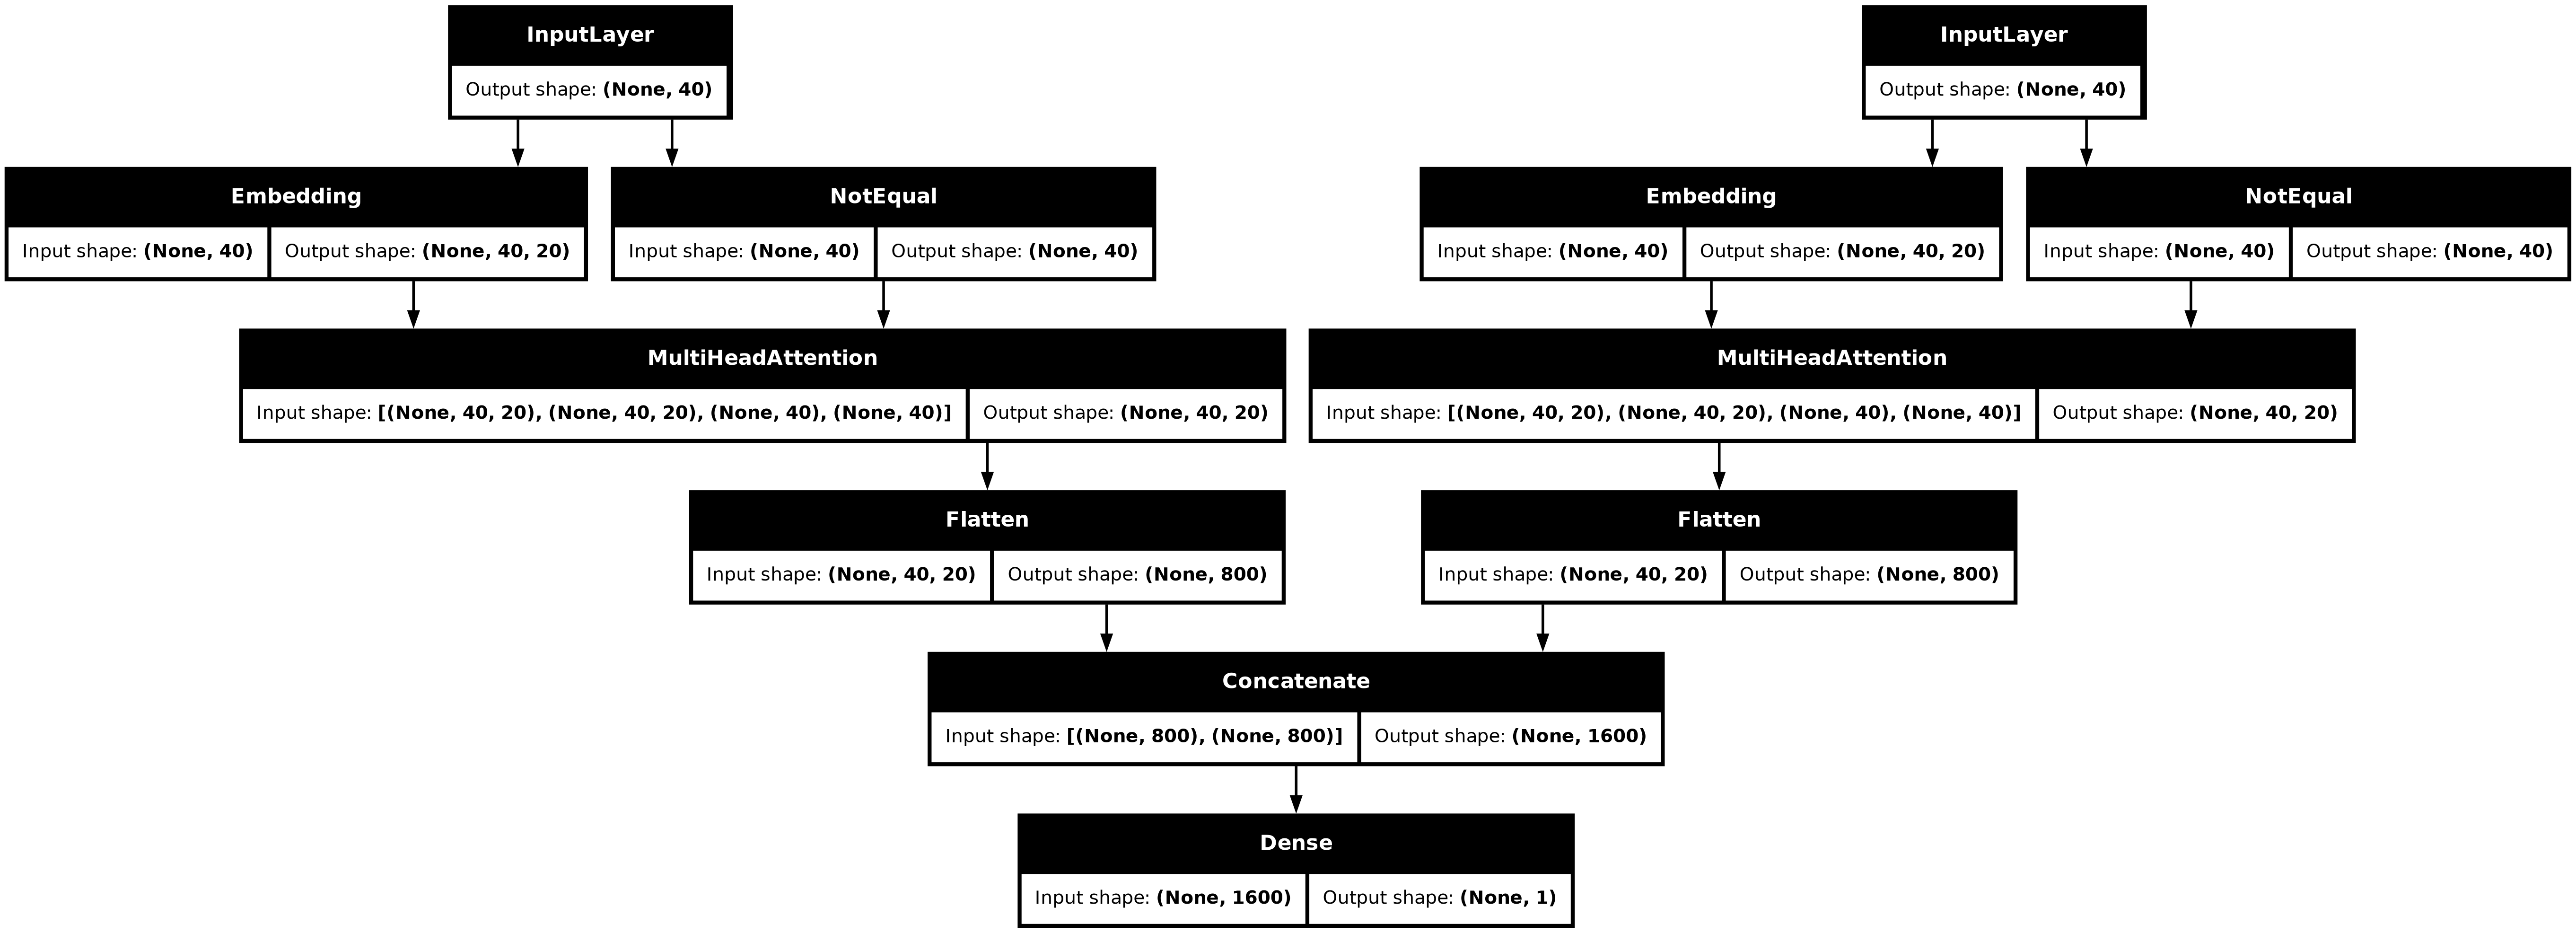

In [53]:
tf.keras.utils.plot_model(model_base, show_shapes=True)

In [54]:
start = time.time()
# Training

# Callback for Early stopping
early_stopping_base = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=20)

history_base = model_base.fit(
    x=[X_train1, X_train2],
    y=y_train,
    batch_size=32,
    epochs=100,
    callbacks=early_stopping_base,
    validation_data = ([X_val1, X_val2], y_val))

print("Training time: "+str(time.time()-start)+" seconds")

Epoch 1/100


I0000 00:00:1734950361.166686     130 service.cc:145] XLA service 0x78ea3c00d000 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734950361.166742     130 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1734950361.166746     130 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  75/1544 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5576 - loss: 0.6879

I0000 00:00:1734950363.310034     130 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1544/1544 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5613 - loss: 0.6862 - val_accuracy: 0.5666 - val_loss: 0.6819
Epoch 2/100
1544/1544 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5916 - loss: 0.6702 - val_accuracy: 0.5594 - val_loss: 0.6847
Epoch 3/100
1544/1544 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6064 - loss: 0.6594 - val_accuracy: 0.5546 - val_loss: 0.6905
Epoch 4/100
1544/1544 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6146 - loss: 0.6497 - val_accuracy: 0.5472 - val_loss: 0.6912
Epoch 5/100
1544/1544 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6243 - loss: 0.6402 - val_accuracy: 0.5456 - val_loss: 0.7020
Epoch 6/100
1544/1544 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6258 - loss: 0.6364 - val_accuracy: 0.5484 - val_loss: 0.7082
Epoch 7/100
1544/1544 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6334 - loss: 0.6281 - val_accuracy: 0.5505 - val_loss: 0.6978
Epoch 8/100
1544/1544 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6389 - loss: 0.6209 - val

In [55]:
# Function to plot loss and accuracy
def loss_acc_plot(history, title=""):
    fig, ax = plt.subplots(1,2)
    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].set_title('Loss')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].legend(['Training', 'Validation'], loc='upper right')
    
    ax[1].plot(history.history['accuracy'])
    ax[1].plot(history.history['val_accuracy'])
    ax[1].set_title('Accuracy')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Training', 'Validation'], loc='upper right')
    fig.tight_layout()
    fig.suptitle(title, x=0.5, y=1.02)
    plt.show()

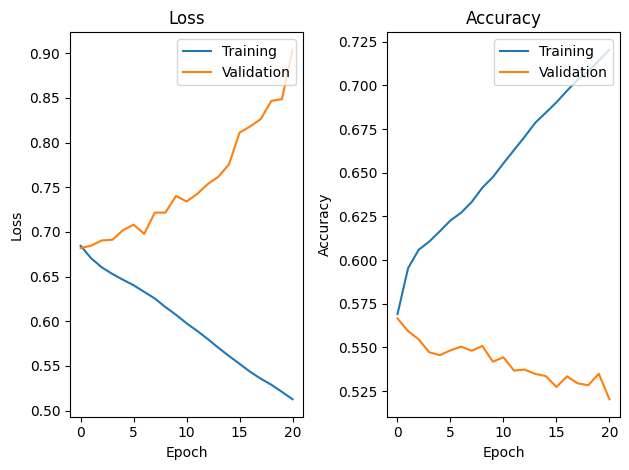

In [56]:
loss_acc_plot(history_base)

In [57]:
# Get the metrics
metrics_model_base = model_base.evaluate(x=[X_test1, X_test2],
    y=y_test)
metrics_model_base

250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5228 - loss: 0.8803


[0.890379786491394, 0.515250027179718]

We have created a model with two inputs, one for each sentence in each pair. Each sentence has been processed with an embedding layer to convert each token (the numerical representation of the words) into a vector representation. In this case, we did not encode the positional information of the words. Next, we passed these vectors through a MultiHeadAttention layer with two heads, which allows for a richer representation of the information compared to an attention layer with a single head. This is the layer where the Query, Key, and Value matrices are located, and thus where the "attention mechanism" occurs. Afterward, we flattened the output, concatenated it, and passed it through a single-neuron output layer (since we have two classes).

In the network implementation, I decided to use Adam as the optimizer because it is one of the best for Transformers. Additionally, I introduced an EarlyStopping callback with a patience of 20 to prevent excessive overfitting. I also set the `mask_zeros` parameter of the Embedding layer to True so that the network ignores OOV tokens during learning. However, leaving it as False (the default) does not significantly change the result.

Regarding overfitting, it is quite severe and suggests that there might be a programming error in the data selection process, although I couldn’t find any. The training set loss gradually decreases, but we do not observe this decrease in the validation set. On the contrary, the validation loss increases. The opposite happens with accuracy. This indicates that the model, in simple terms, is learning the correct answers to the training instances without extracting meaningful information about the task.

As we see with the final model accuracy (after training stops due to the callback), the test set accuracy is very low, around 53%, which is close to what a hypothetical random model would achieve by only learning the proportion of instances. How can we address this overfitting problem? Below, I attempt to do so by adding dropout layers, but with limited success. It is possible that the entire problem stems from the size of the training dataset.








## 4. Modifying attention layer

Embedding layers that feed into attention layers are typically more effective when they preserve not only vector information but also positional information about the text. To achieve this, we will create a class that performs the following steps:

1. It computes token embeddings using an embedding layer, as in the previous example.
2. It additionally computes positional embeddings corresponding to the positions of the words. For this, the input_dim parameter will be set to the maximum sentence length calculated earlier.
3. Finally, it concatenates both embeddings (token and positional).

We will replace the embedding layer from the previous exercise with this new one you have created

In [58]:
class EmbeddingPosition(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.embedding_words = tf.keras.layers.Embedding(input_dim=5000, output_dim=20, input_length=40 , mask_zero=True)
        self.embedding_positions = tfm.nlp.layers.PositionEmbedding(max_length=40)
                        
    def call(self, inputs):
        x = self.embedding_words(inputs)
        y = self.embedding_positions(x)
        return tf.keras.layers.Concatenate()([x, y])

In [59]:
# Definition of the network
input1 = tf.keras.Input(shape=(40,))
input2 = tf.keras.Input(shape=(40,))

embedding1 = EmbeddingPosition()(input1)
embedding2 = EmbeddingPosition()(input2)

attention1 = tf.keras.layers.MultiHeadAttention(num_heads=2, key_dim=20)(embedding1, embedding1)
attention2 = tf.keras.layers.MultiHeadAttention(num_heads=2, key_dim=20)(embedding2, embedding2)

flatten1 = tf.keras.layers.Flatten()(attention1)
flatten2 = tf.keras.layers.Flatten()(attention2)

concatenate = tf.keras.layers.Concatenate()([flatten1, flatten2])

output = tf.keras.layers.Dense(1, activation="sigmoid")(concatenate)

model_custom_embedding = Model(inputs = [input1, input2], outputs = output)

In [60]:
# Compile
model_custom_embedding.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.BinaryCrossentropy(), metrics=["accuracy"])
model_custom_embedding.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 40)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, 40)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_position  │ (None, 40, 40)    │    100,000 │ input_layer_2[0]… │
│ (EmbeddingPosition) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_position… │ (None, 40, 40)    │    100,000 │ input_layer_3[0]… │
│ (EmbeddingPosition) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 40, 40)    │      6,560 │ embedding_positi… │
│ (MultiHeadAttentio… │                   │            │ embedding_positi… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 40, 40)    │      6,560 │ embedding_positi… │
│ (MultiHeadAttentio… │                   │            │ embedding_positi… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 1600)      │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_3 (Flatten) │ (None, 1600)      │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_5       │ (None, 3200)      │          0 │ flatten_2[0][0],  │
│ (Concatenate)       │                   │            │ flatten_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │      3,201 │ concatenate_5[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 216,321 (845.00 KB)

 Trainable params: 216,321 (845.00 KB)

 Non-trainable params: 0 (0.00 B)

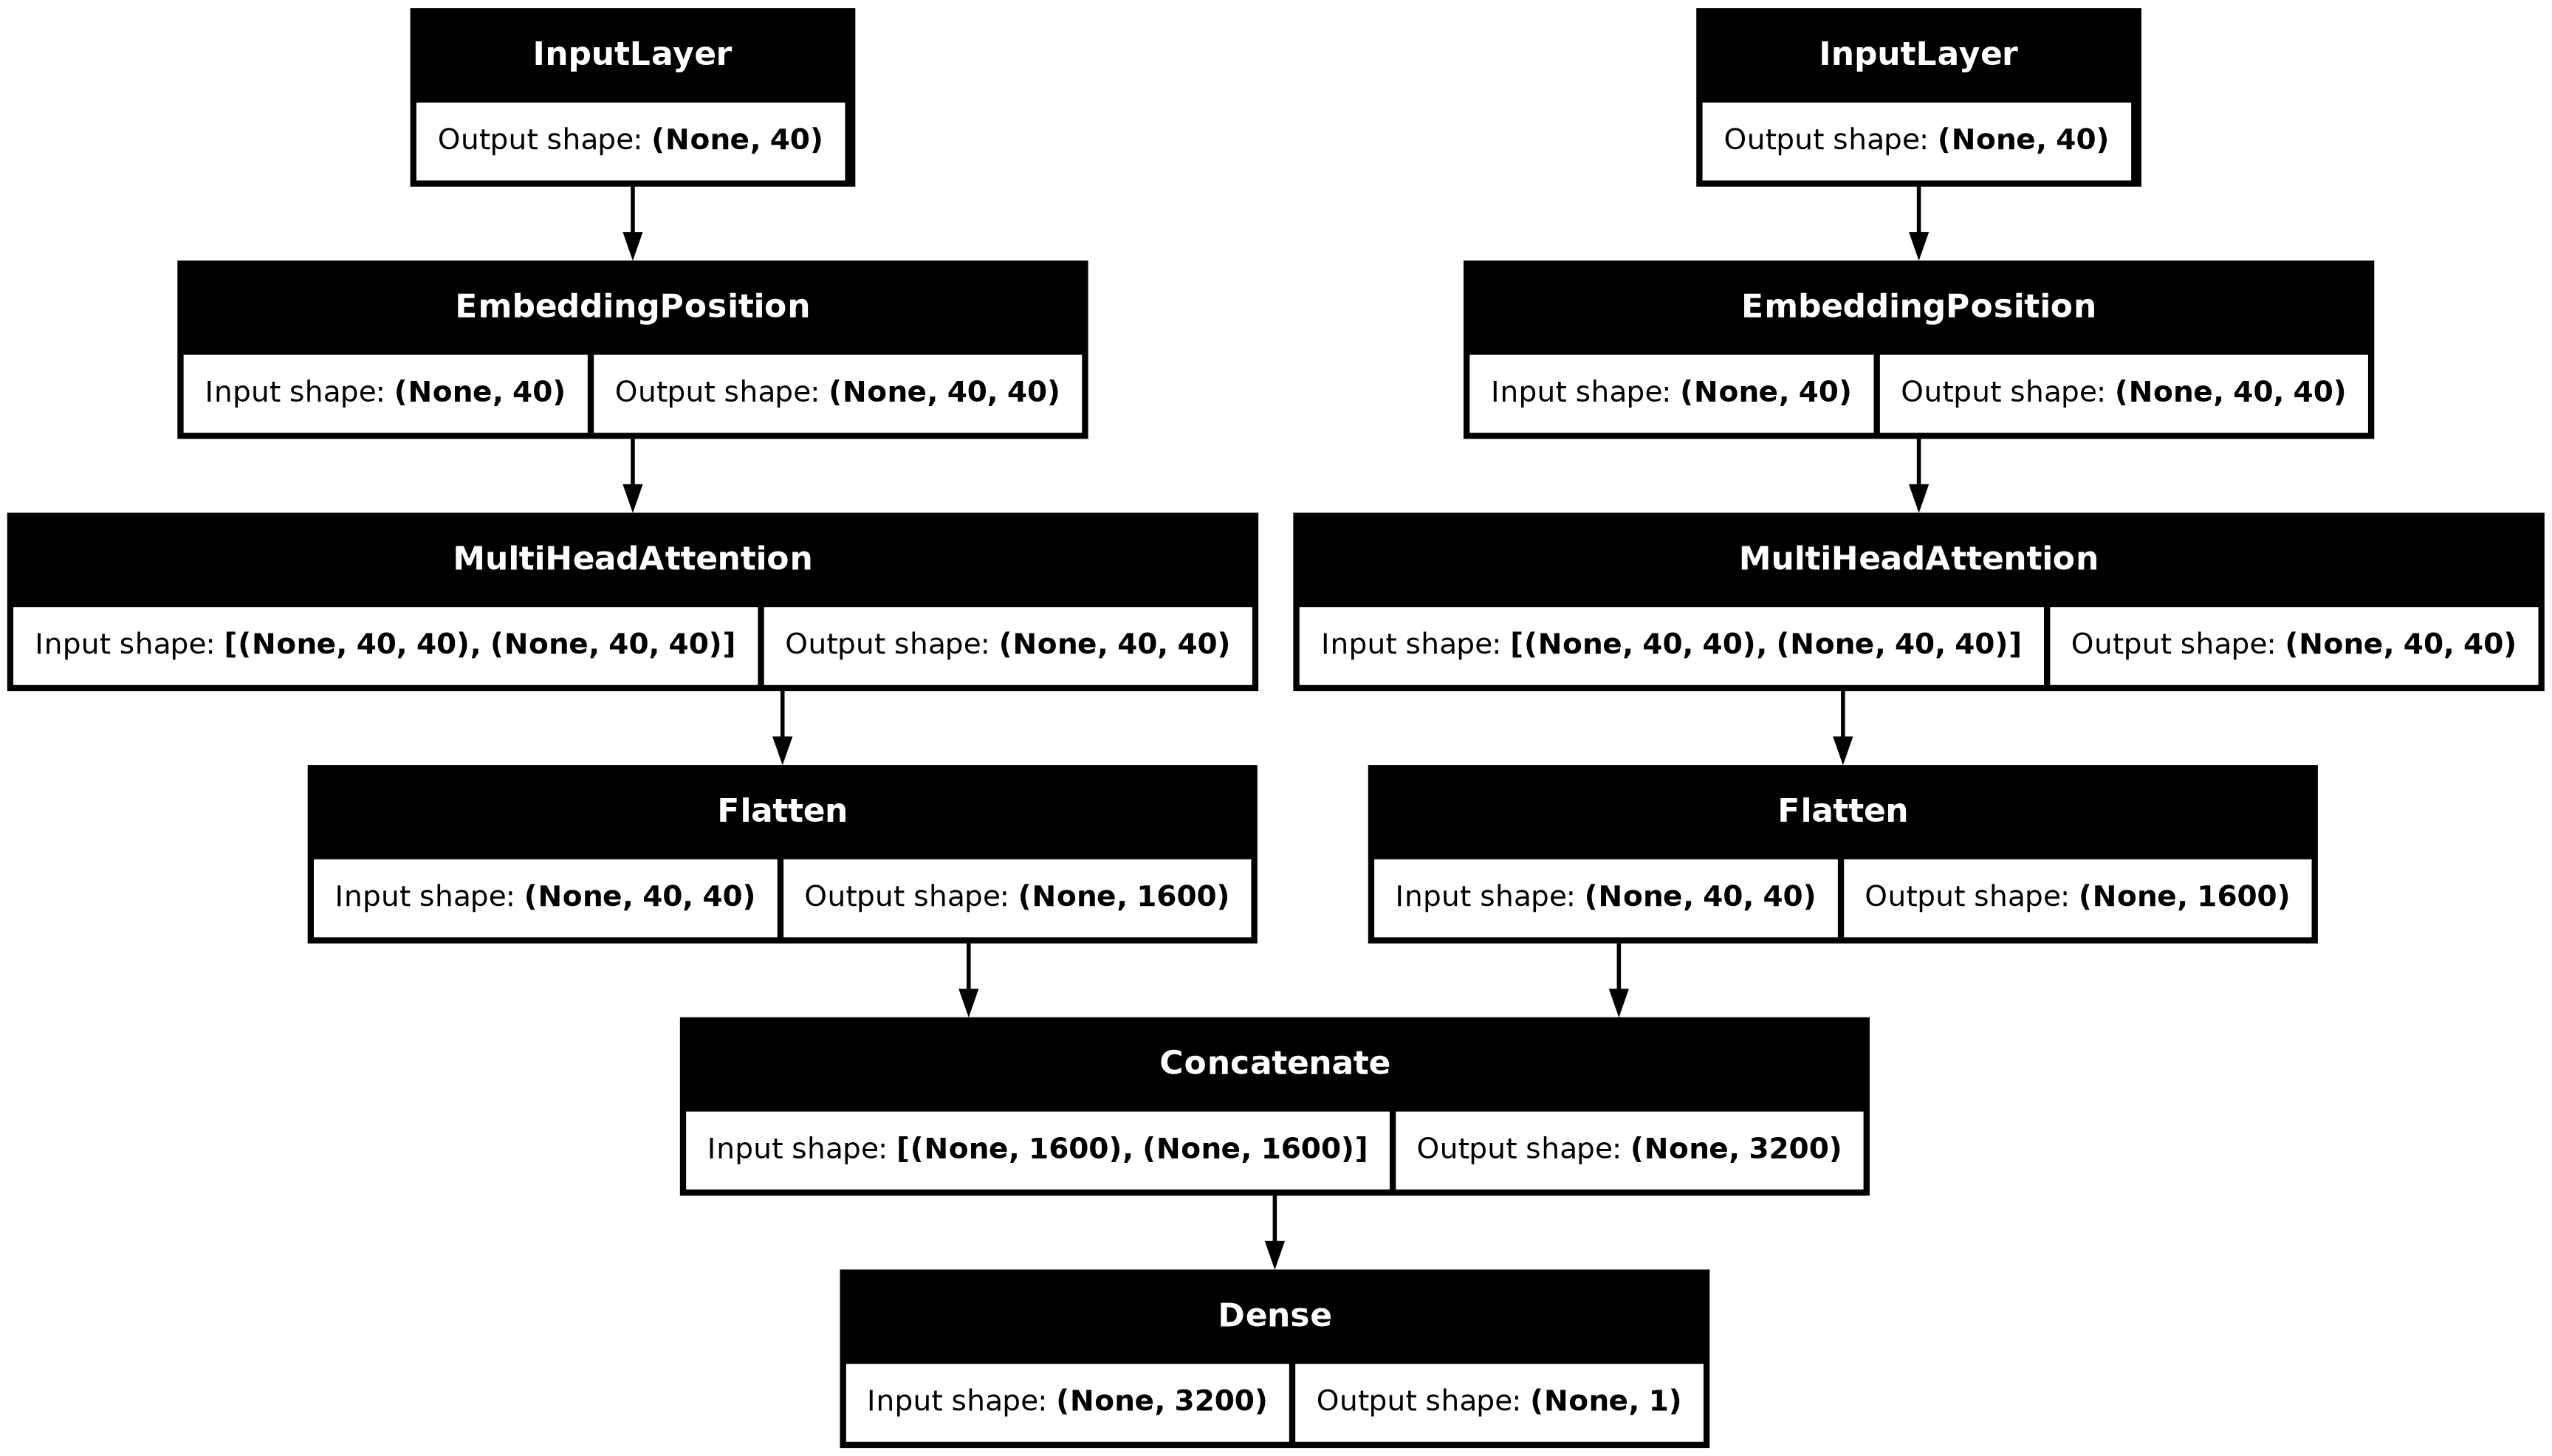

In [61]:
tf.keras.utils.plot_model(model_custom_embedding, show_shapes=True)

In [62]:
start = time.time()
# Training

# Callback for Early stopping
early_stopping_custom_embedding = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=20)

history_custom_embedding = model_custom_embedding.fit(
    x=[X_train1, X_train2],
    y=y_train,
    epochs=100,
    callbacks=early_stopping_custom_embedding,
    validation_data = ([X_val1, X_val2], y_val))

print("Training time: "+str(time.time()-start)+" seconds")

Epoch 1/100
1544/1544 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.5573 - loss: 0.6872 - val_accuracy: 0.5500 - val_loss: 0.6890
Epoch 2/100
1544/1544 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.5861 - loss: 0.6739 - val_accuracy: 0.5626 - val_loss: 0.6870
Epoch 3/100
1544/1544 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6090 - loss: 0.6549 - val_accuracy: 0.5566 - val_loss: 0.6915
Epoch 4/100
1544/1544 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6186 - loss: 0.6442 - val_accuracy: 0.5555 - val_loss: 0.6967
Epoch 5/100
1544/1544 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6237 - loss: 0.6365 - val_accuracy: 0.5555 - val_loss: 0.7103
Epoch 6/100
1544/1544 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6262 - loss: 0.6299 - val_accuracy: 0.5526 - val_loss: 0.7045
Epoch 7/100
1544/1544 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6370 - loss: 0.6197 - val_accuracy: 0.5493 - val_loss: 0.7147
Epoch 8/100
1544/1544 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6451 - loss: 

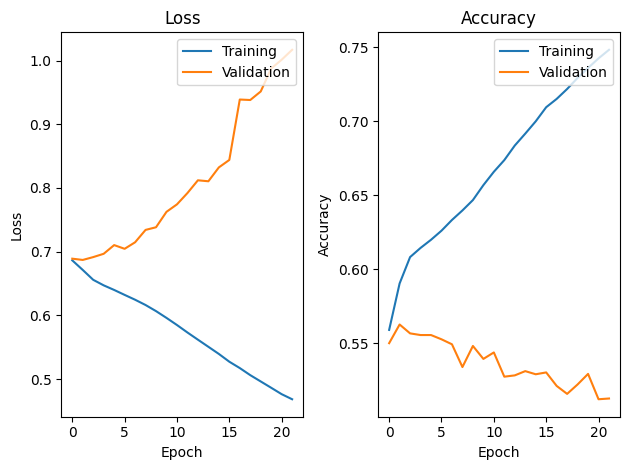

In [63]:
loss_acc_plot(history_custom_embedding)

In [64]:
# Calculate metrics
metrics_model_custom_embedding = model_custom_embedding.evaluate(x=[X_test1, X_test2],
    y=y_test)
metrics_model_custom_embedding

250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5248 - loss: 0.9880


[1.0062358379364014, 0.5249999761581421]

This time, we created a class to incorporate both positional embeddings and token embeddings simultaneously. We introduced this layer by replacing the previous embedding layer and retrained the model.

We observe that even with this double, concatenated embedding, the results did not improve. Overfitting remains pronounced, and the validation set accuracy continues to decline compared to the previous setup. We are still below 53%, very close to what a random model would achieve.








## 4.1. EXTRA: Network with positional embedding, an additional dense layer, and 3 dropout layers

To test ways of reducing overfitting in the network, I will train another model, this time with a dropout layer after each attention layer. Additionally, I am introducing an extra dense layer and another dropout layer after this dense layer and before the output.

Moreover, although not shown here, I have also tested (without improving the results) adding dropout layers after the attention layers but without introducing the extra dense layer and its corresponding dropout. The dropout rates (0.2 for the attention layers and 0.5 for the adjustment layer) were chosen based on documentation I found regarding common values for these layers.

In [65]:
# Network definition
input1 = tf.keras.Input(shape=(40,))
input2 = tf.keras.Input(shape=(40,))

embedding1 = EmbeddingPosition()(input1)
embedding2 = EmbeddingPosition()(input2)

attention1 = tf.keras.layers.MultiHeadAttention(num_heads=2, key_dim=20)(embedding1, embedding1)
attention2 = tf.keras.layers.MultiHeadAttention(num_heads=2, key_dim=20)(embedding2, embedding2)

dropout1 = tf.keras.layers.Dropout(rate=0.2)(attention1)
dropout2 = tf.keras.layers.Dropout(rate=0.2)(attention2)

flatten1 = tf.keras.layers.Flatten()(dropout1)
flatten2 = tf.keras.layers.Flatten()(dropout2)

concatenate = tf.keras.layers.Concatenate()([flatten1, flatten2])

dense = tf.keras.layers.Dense(32, activation="relu")(concatenate)

dropout = tf.keras.layers.Dropout(rate=0.5)(dense)

output = tf.keras.layers.Dense(1, activation="sigmoid")(dropout)

model_custom_embedding_dropout = Model(inputs = [input1, input2], outputs = output)

In [66]:
# Compining
model_custom_embedding_dropout.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.BinaryCrossentropy(), metrics=["accuracy"])
model_custom_embedding_dropout.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 40)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_5       │ (None, 40)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_position… │ (None, 40, 40)    │    100,000 │ input_layer_4[0]… │
│ (EmbeddingPosition) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_position… │ (None, 40, 40)    │    100,000 │ input_layer_5[0]… │
│ (EmbeddingPosition) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 40, 40)    │      6,560 │ embedding_positi… │
│ (MultiHeadAttentio… │                   │            │ embedding_positi… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 40, 40)    │      6,560 │ embedding_positi… │
│ (MultiHeadAttentio… │                   │            │ embedding_positi… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 40, 40)    │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 40, 40)    │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_4 (Flatten) │ (None, 1600)      │          0 │ dropout_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_5 (Flatten) │ (None, 1600)      │          0 │ dropout_7[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_16      │ (None, 3200)      │          0 │ flatten_4[0][0],  │
│ (Concatenate)       │                   │            │ flatten_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 32)        │    102,432 │ concatenate_16[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 32)        │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │         33 │ dropout_8[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 315,585 (1.20 MB)

 Trainable params: 315,585 (1.20 MB)

 Non-trainable params: 0 (0.00 B)

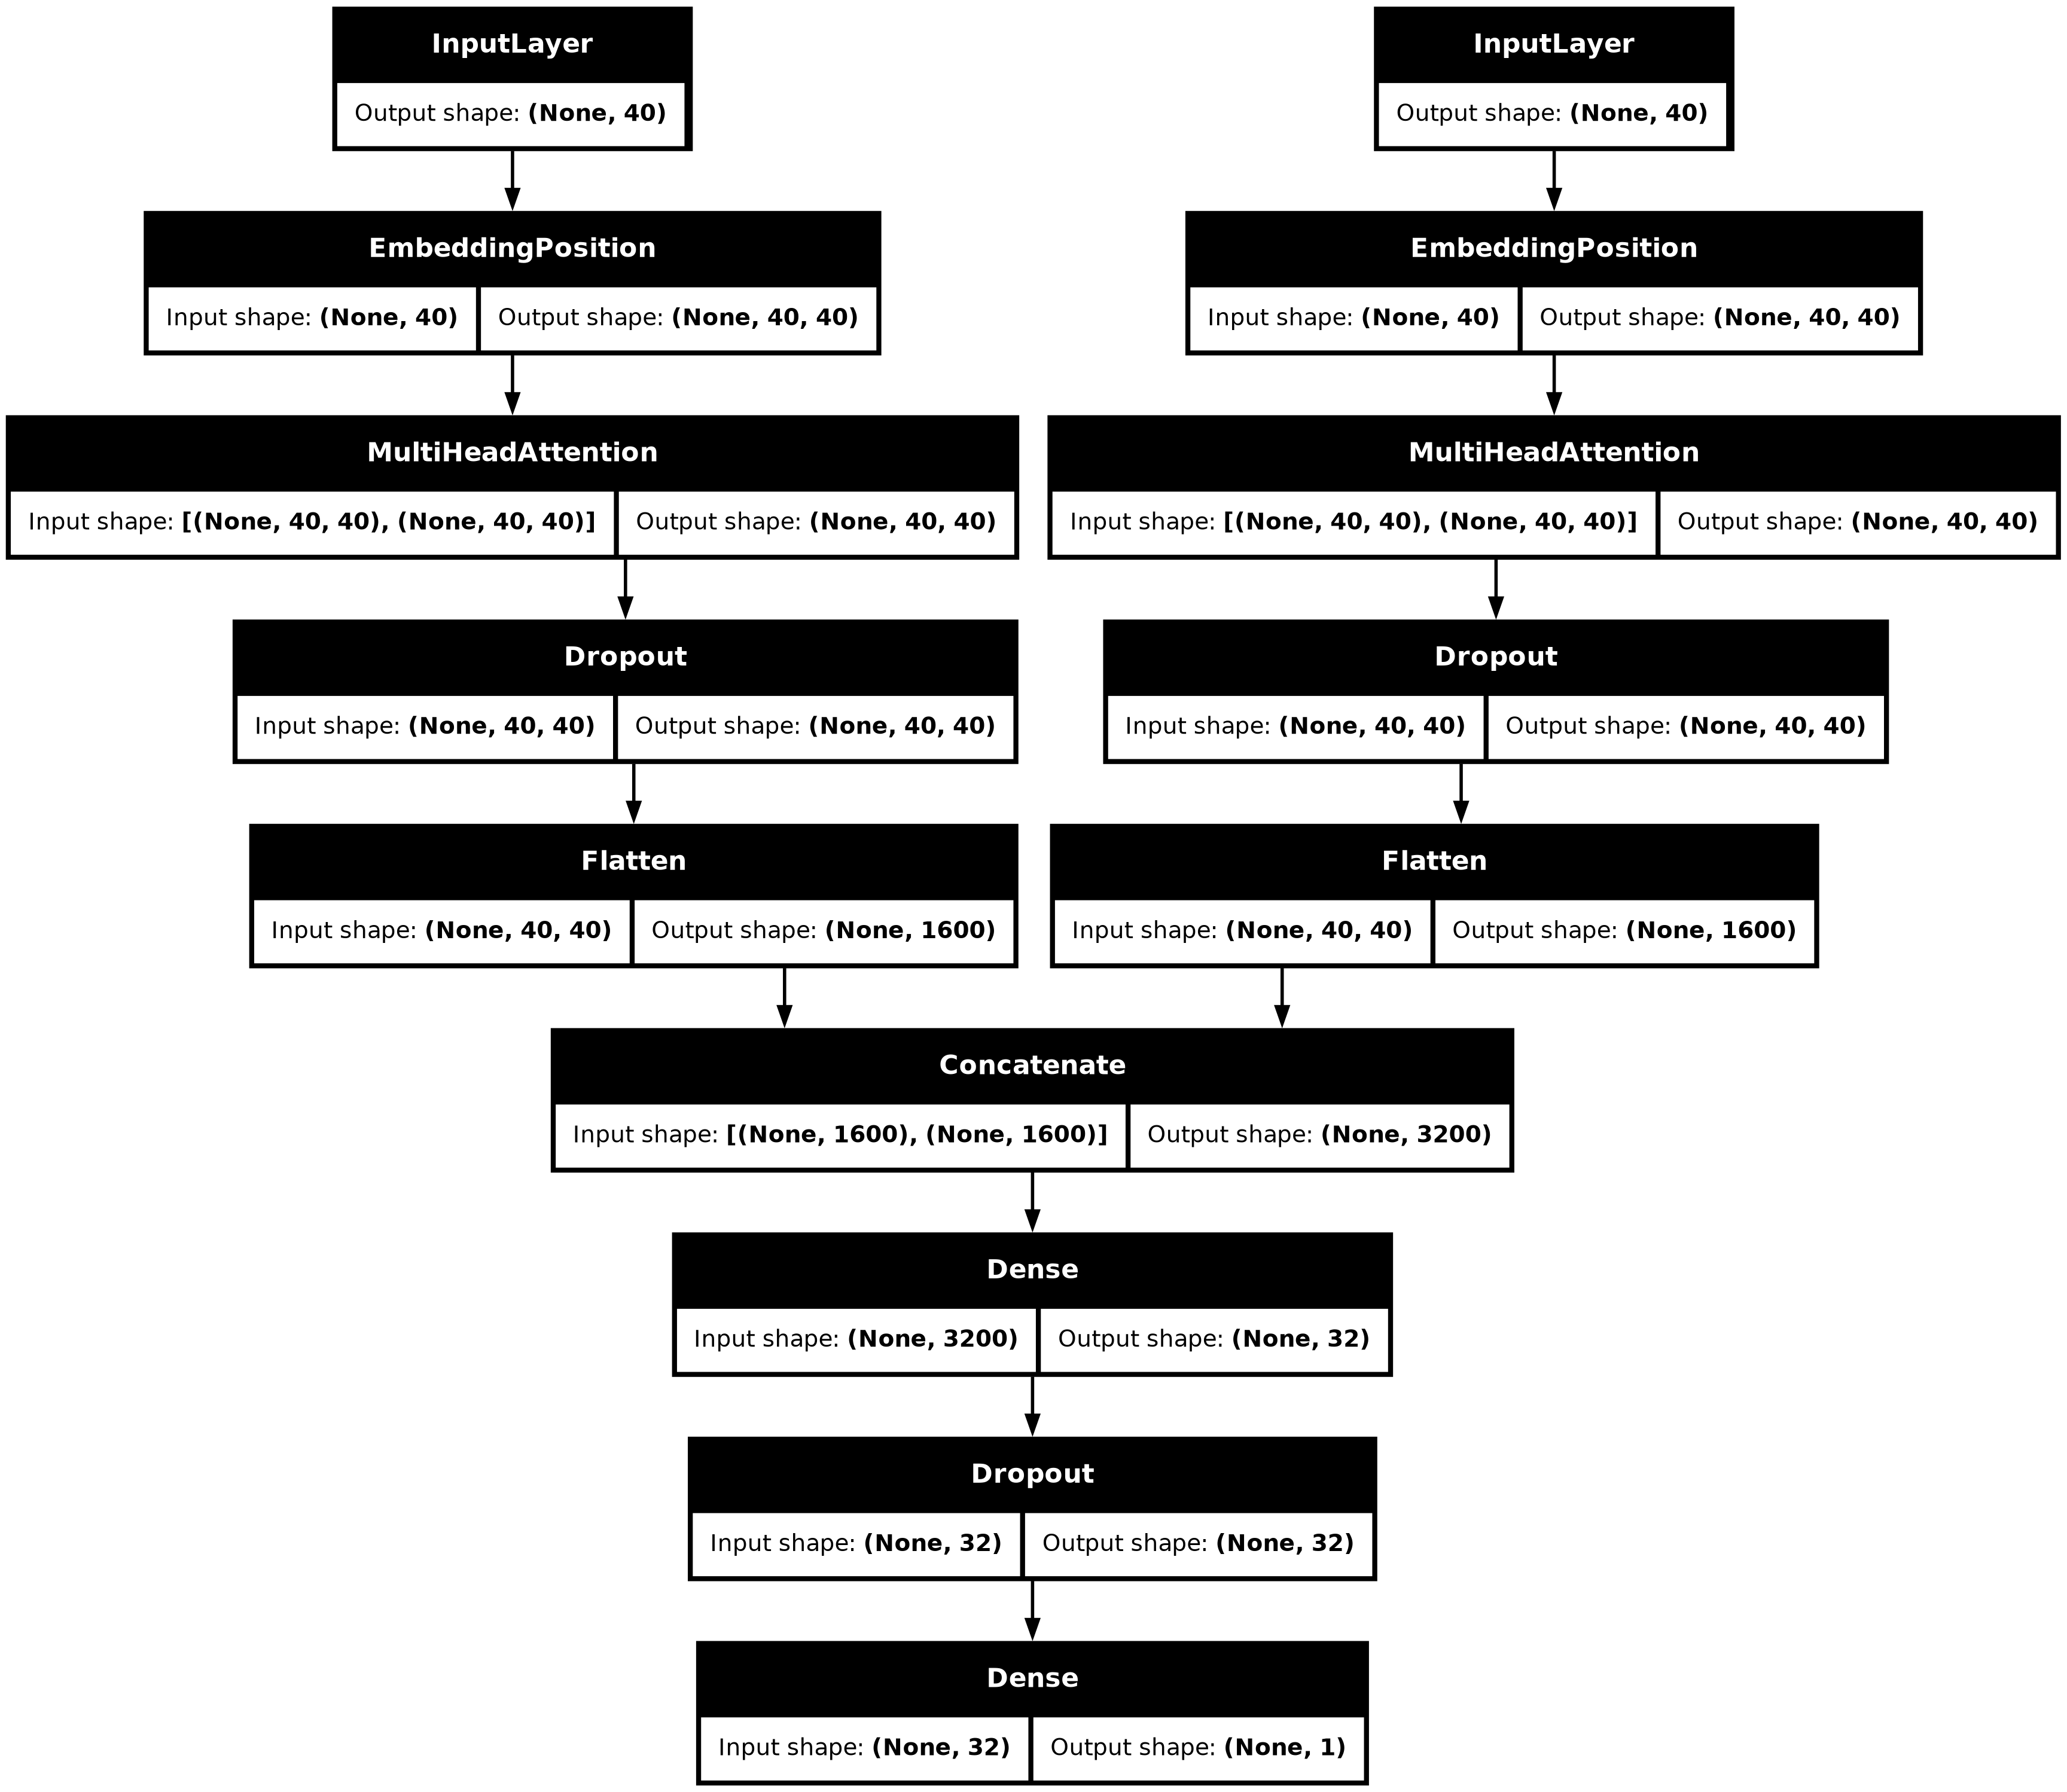

In [67]:
tf.keras.utils.plot_model(model_custom_embedding_dropout, show_shapes=True)

In [68]:
start = time.time()
# Training

# Callback for Early stopping
early_stopping_custom_embedding_dropout = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=20)

history_custom_embedding_dropout = model_custom_embedding_dropout.fit(
    x=[X_train1, X_train2],
    y=y_train,
    epochs=100,
    callbacks=early_stopping_custom_embedding_dropout,
    validation_data = ([X_val1, X_val2], y_val))

print("Training time: "+str(time.time()-start)+" seconds")

Epoch 1/100
1544/1544 ━━━━━━━━━━━━━━━━━━━━ 18s 7ms/step - accuracy: 0.5511 - loss: 0.6893 - val_accuracy: 0.5576 - val_loss: 0.6866
Epoch 2/100
1544/1544 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.5569 - loss: 0.6869 - val_accuracy: 0.5576 - val_loss: 0.6865
Epoch 3/100
1544/1544 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.5550 - loss: 0.6871 - val_accuracy: 0.5576 - val_loss: 0.6865
Epoch 4/100
1544/1544 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.5610 - loss: 0.6857 - val_accuracy: 0.5576 - val_loss: 0.6865
Epoch 5/100
1544/1544 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.5556 - loss: 0.6870 - val_accuracy: 0.5576 - val_loss: 0.6865
Epoch 6/100
1544/1544 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.5609 - loss: 0.6857 - val_accuracy: 0.5576 - val_loss: 0.6866
Epoch 7/100
1544/1544 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.5557 - loss: 0.6870 - val_accuracy: 0.5576 - val_loss: 0.6865
Epoch 8/100
1544/1544 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.5589 - loss: 

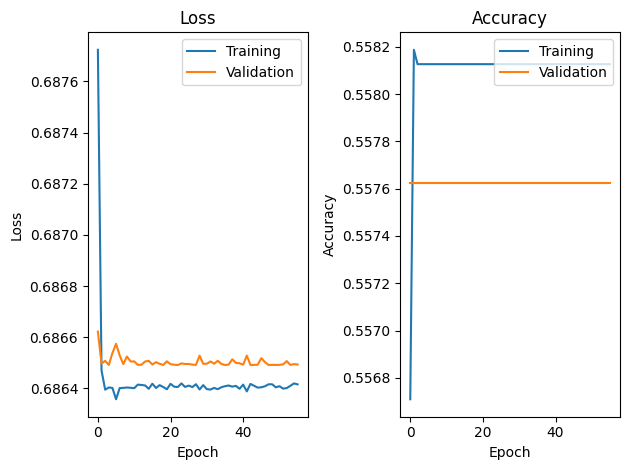

In [69]:
loss_acc_plot(history_custom_embedding_dropout)

In [70]:
# Calculate metrics
history_custom_embedding_dropout = model_custom_embedding_dropout.evaluate(x=[X_test1, X_test2],
    y=y_test)
history_custom_embedding_dropout

250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5587 - loss: 0.6863


[0.6864045858383179, 0.5580000281333923]

We observe that by adding these dropout layers and the dense layer, we are able to slightly improve the test set accuracy (albeit very slightly). However, we still see significant overfitting.








By introducing the LSTM layer, we incorporate sequential processing (instead of processing everything at once) for the sentences we input into the model. This can enrich the information that reaches the attention layer by providing an initial step of abstraction. However, we must not overlook the fact that recurrent networks are not particularly good at handling distant dependencies. Therefore, in sentences where distant elements combine to give meaning, adding this LSTM layer may not be beneficial. What we observe, however, is that adding the LSTM layer does achieve a slight improvement in accuracy, although overfitting is clearly evident, as with the other models we have trained.

Finally, in terms of using a bidirectional layer, it can be beneficial in language processing tasks like this one, where information can be enriched by processing the sentence in both directions. In other tasks, such as time series (e.g., the stock market series mentioned in the prompt), a bidirectional network does not initially seem like the right approach because the typical goal is to use the network to predict future steps, not past ones. However, as far as I have found in published research, bidirectional LSTM layers are frequently used in time series analysis. Although this might seem counterintuitive, they can provide a better representation of context when the outputs of the two "passes" of the network are summed or concatenated. You can see an example of using networks with bidirectional LSTM layers here: link.

## 5. Using pre-trained architectures to enhance training data

In certain cases, it can be a good idea to use pre-trained models not only to fine-tune them for our domain but simply to generate new training data. In our case, it seems we do not have enough data, as exposed by the issues with overfitting. Therefore, in this section we will:

1. Use the model from https://huggingface.co/Vamsi/T5_Paraphrase_Paws to generate new training data (both paraphrases and non-paraphrases).  
2. Retrain the architecture we have built to try to improve the results obtained so far.
3. Try to improve the results by modifying the architecture.

Now, I'll explain the strategy I followed to generate new training data. While I used the model suggested above (T5_Paraphrase_Paws), I did not generate new sentences based on the existing ones but instead from another dataset of sentences. I used a dataset of Wikipedia sentences available here: https://www.kaggle.com/datasets/mikeortman/wikipedia-sentences. This dataset contains 7.8M sentences from Wikipedia. Due to computational time constraints, I created paraphrases (or non-paraphrases) for a subset of these sentences. In total, I generated approximately 90K pairs of paraphrases and 70K pairs of non-paraphrases.

The code used for this purpose can be found in the other notebook in this GitHub repository. 

Essentially, the strategy involves using the proposed model to generate paraphrases, primarily using the model "out of the box." However, the "challenge" lies in generating non-paraphrases. For this, I adjusted the model's parameters, mainly the "temperature" parameter. Lower values for this parameter result in new sentences that are very similar to the originals but not identical. Higher values result in sentences that are much more different, which are typically not paraphrases. I will generate the final dataset using four sources:abs
1. The sentences used for paraphrase generation
2. The generated paraphrase sentences
3. The sentences used for non-paraphrase generation
4. The generated non-paraphrase sentences

I will combine the sources and train the model with them:

In [72]:
# Load the sentences used for paraphrase generation
sentences_for_paraphrase = []

with open("/kaggle/input/sentences-for-paraphrase-detection/sentences_for_paraphrase.txt") as file:
    for item in file:
        sentences_for_paraphrase.append(item)

In [73]:
# Load the generated paraphrases
sentences_paraphrased = []

with open("/kaggle/input/sentences-for-paraphrase-detection/sentences_paraphrased.txt") as file:
    for item in file:
        sentences_paraphrased.append(item)

In [74]:
# There are more sentences used for paraphrase generation than the total number of paraphrases generated. We need to get only the sentences for which we generated a paraphrase

sentences_for_paraphrase = sentences_for_paraphrase[0:len(sentences_paraphrased)]

Show an example of paraphrases:

In [75]:
sentences_for_paraphrase[1]

'A small portion of southwestern Travis County also lies within the district.\n'

In [76]:
sentences_paraphrased[1]

'Nearby sits also a small portion of the southwestern Travis County.\n'

In [79]:
# Load the sentences used for non-paraphrase generation
sentences_for_non_paraphrase = []

with open("/kaggle/input/sentences-for-paraphrase-detection/sentences_for_non_paraphrase.txt") as file:
    for item in file:
        sentences_for_non_paraphrase.append(item)

In [80]:
# Load the generated non-paraphrases
sentences_non_paraphrased = []

with open("/kaggle/input/sentences-for-paraphrase-detection/sentences_non_paraphrased.txt") as file:
    for item in file:
        sentences_non_paraphrased.append(item)

In [81]:
# There are more sentences used for non-paraphrase generation than the total number of non-paraphrases generated. We need to get only the sentences for which we generated a non-paraphrase

sentences_for_non_paraphrase = sentences_for_non_paraphrase[0:len(sentences_non_paraphrased)]

In [82]:
sentences_for_non_paraphrase[1]

'It is the only MLS game to have been released on the PlayStation.\n'

In [83]:
sentences_non_paraphrased[1]

'It is currently known as MLS game alone has that has debuted on the PlayStation store.\n'

I must say that selecting the temperature value for generating non-paraphrases is complicated. Sometimes it returns phrases that are clearly not paraphrases but also don't make much sense, as in the last case I just showed.

## 5.1. Data loading, preprocessing, visualization

Since we already have the phrases in lists, there's no need to decode them. To generate the training, validation, and test sets, we simply need to take the desired fraction of phrases for each set. But first, I’m going to create the labels.

In [84]:
labels_paraphrases = [1 for el in range(len(sentences_paraphrased))]
labels_non_paraphrases = [0 for el in range(len(sentences_non_paraphrased))]

I want to shuffle the data before splitting it. To do this, I combine the pairs of phrases with their labels, both for paraphrases and non-paraphrases. Then, I merge the two sets (paraphrases and non-paraphrases), shuffle them, and afterwards separate the phrase pairs from each other and from the labels to generate the final sets.

In [85]:
union_paraphrases = list(zip(sentences_for_paraphrase, sentences_paraphrased, labels_paraphrases))
union_non_paraphrases = list(zip(sentences_for_non_paraphrase, sentences_non_paraphrased, labels_non_paraphrases))

In [86]:
union_paraphrases[1]

('A small portion of southwestern Travis County also lies within the district.\n',
 'Nearby sits also a small portion of the southwestern Travis County.\n',
 1)

In [87]:
union_non_paraphrases[1]

('It is the only MLS game to have been released on the PlayStation.\n',
 'It is currently known as MLS game alone has that has debuted on the PlayStation store.\n',
 0)

In [89]:
all_phrases = union_paraphrases + union_non_paraphrases

In [90]:
import random
random.shuffle(all_phrases)

In [91]:
all_phrases[0]

('It was developed by the Apache Software Foundation for the Web Publishing Framework Cocoon.\n',
 'And because she was developed and controlled by the Apache Software Foundation for the cocoon authoring content therewebmsgnet database.\n',
 0)

In [92]:
# Undo the zip and separate the sets

sentence1_new, sentence2_new, label_new = zip(*all_phrases)

In [93]:
sentence1_new = list(sentence1_new)
sentence2_new = list(sentence2_new)
label_new = list(label_new)

In [94]:
# Incase there is any tuple, eliminate it
for el in sentence1_new[:]:
    if type(el) == tuple:
        sentence1_new.remove(el)
        
for el in sentence2_new[:]:
    if type(el) == tuple:
        sentence2_new.remove(el)
        
for el in label_new[:]:
    if type(el) == tuple:
        label_new.remove(el)

In [95]:
for el in range(len(sentence1_new)):
    if type(sentence1_new[el])==tuple:
        print(sentence1_new[el])

In [96]:
for el in range(len(sentence2_new)):
    if type(sentence2_new[el])==tuple:
        print(sentence2_new[el])

In [97]:
sentence1_new[-1]

'Volunteer members advocate, educate, and raise funds on behalf of the Library, its patrons, and the larger community.\n'

In [98]:
sentence2_new[-1]

'Volunteer members advocate, educate, and raise money on behalf of the Library, its patrons and the larger community.\n'

In [99]:
label_new[-1]

1

We will use 90% of data for training, 5% for validation and 5% for test

In [100]:
train_proportion = int(len(sentence1_new)*0.9)
val_proportion = int(len(sentence1_new)*0.05)

In [101]:
# Prepare training set
train_sentence1_new = sentence1_new[:train_proportion]
train_sentence2_new = sentence2_new[:train_proportion]
train_label_new = label_new[:train_proportion]

In [102]:
# Prepare validation set
val_sentence1_new = sentence1_new[train_proportion:(train_proportion+val_proportion)]
val_sentence2_new = sentence2_new[train_proportion:(train_proportion+val_proportion)]
val_label_new = label_new[train_proportion:(train_proportion+val_proportion)]

In [103]:
# Prepare test set
test_sentence1_new = sentence1_new[(train_proportion+val_proportion):]
test_sentence2_new = sentence2_new[(train_proportion+val_proportion):]
test_label_new = label_new[(train_proportion+val_proportion):]

In [104]:
# Show number of elements in each list
objects = [train_sentence1_new, train_sentence2_new, train_label_new, val_sentence1_new, val_sentence2_new, val_label_new, test_sentence1_new, test_sentence2_new, test_label_new]
objects_names = ["train_sentence1_new", "train_sentence2_new", "train_label_new", "val_sentence1_new", "val_sentence2_new", "val_label_new", "test_sentence1_new", "test_sentence2_new", "test_label_new"]

for el in range(len(objects)):
    print("Size of "+objects_names[el]+": "+str(len(objects[el])))

Size of train_sentence1_new: 153001
Size of train_sentence2_new: 153001
Size of train_label_new: 153001
Size of val_sentence1_new: 8500
Size of val_sentence2_new: 8500
Size of val_label_new: 8500
Size of test_sentence1_new: 8501
Size of test_sentence2_new: 8501
Size of test_label_new: 8501


We will use the same tokenizer we used before

In [105]:
# Tokenize sets
tokenized_train_sentence1_new = tokenizer.texts_to_sequences(train_sentence1_new)
tokenized_train_sentence2_new = tokenizer.texts_to_sequences(train_sentence2_new)

tokenized_val_sentence1_new = tokenizer.texts_to_sequences(val_sentence1_new)
tokenized_val_sentence2_new = tokenizer.texts_to_sequences(val_sentence2_new)

tokenized_test_sentence1_new = tokenizer.texts_to_sequences(test_sentence1_new)
tokenized_test_sentence2_new = tokenizer.texts_to_sequences(test_sentence2_new)

In [106]:
# Add padding with the length of the longest sentence
X_train1_new = pad_sequences(
    tokenized_train_sentence1_new,
    maxlen=longest_sentence)

X_train2_new = pad_sequences(
    tokenized_train_sentence2_new,
    maxlen=longest_sentence)

X_val1_new = pad_sequences(
    tokenized_val_sentence1_new,
    maxlen=longest_sentence)

X_val2_new = pad_sequences(
    tokenized_val_sentence2_new,
    maxlen=longest_sentence)

X_test1_new = pad_sequences(
    tokenized_test_sentence1_new,
    maxlen=longest_sentence)

X_test2_new = pad_sequences(
    tokenized_test_sentence2_new,
    maxlen=longest_sentence)

In [107]:
# Cast labels to numpy.array
y_train_new = np.array(train_label_new)
y_val_new = np.array(val_label_new)
y_test_new = np.array(test_label_new)

In [108]:
y_train_new[:10]

array([0, 1, 0, 1, 0, 1, 0, 1, 1, 1])

In [109]:
# Show set dimensions
conjuntos = [X_train1_new, X_train2_new, X_val1_new, X_val2_new, X_test1_new, X_test2_new, y_train_new, y_val_new, y_test_new]
nombres_conjuntos = ["X_train1_new", "X_train2_new", "X_val1_new", "X_val2_new", "X_test1_new", "X_test2_new", "y_train_new", "y_val_new", "y_test_new"]

print("Set dimensions")

for el in range(len(conjuntos)):
    print(nombres_conjuntos[el]+": "+str(conjuntos[el].shape))

Set dimensions
X_train1_new: (153001, 40)
X_train2_new: (153001, 40)
X_val1_new: (8500, 40)
X_val2_new: (8500, 40)
X_test1_new: (8501, 40)
X_test2_new: (8501, 40)
y_train_new: (153001,)
y_val_new: (8500,)
y_test_new: (8501,)


Check if the proportions of labels are balanced

In [110]:
train_unique_new, train_counts_new = np.unique(y_train_new, return_counts=True)

print("Proportion of 0 labels in y_train_new: "+str(round(
    train_counts_new[0]/(train_counts_new[0]+train_counts_new[1]),2)))

print("Proportion of 1 labels in y_train_new: "+str(round(
    train_counts_new[1]/(train_counts_new[0]+train_counts_new[1]),2)))

Proportion of 0 labels in y_train_new: 0.47
Proportion of 1 labels in y_train_new: 0.53


In [111]:
val_unique_new, val_counts_new = np.unique(y_val_new, return_counts=True)

print("Proportion of 0 labels in y_val_new: "+str(round(
    val_counts_new[0]/(val_counts_new[0]+val_counts_new[1]),2)))

print("Proportion of 1 labels in y_val_new: "+str(round(
    val_counts_new[1]/(val_counts_new[0]+val_counts_new[1]),2)))

Proportion of 0 labels in y_val_new: 0.46
Proportion of 1 labels in y_val_new: 0.54


In [112]:
test_unique_new, test_counts_new = np.unique(y_test_new, return_counts=True)

print("Proportion of 0 labels in y_test_new: "+str(round(
    test_counts_new[0]/(test_counts_new[0]+test_counts_new[1]),2)))

print("Proportion of 1 labels in y_test_new: "+str(round(
    test_counts_new[1]/(test_counts_new[0]+test_counts_new[1]),2)))

Proportion of 0 labels in y_test_new: 0.46
Proportion of 1 labels in y_test_new: 0.54


Once we have the data ready, we will create a new network based on the network we generated, including the dropout layers and the additional dense layer:

In [113]:
# Network definition
input1 = tf.keras.Input(shape=(40,))
input2 = tf.keras.Input(shape=(40,))

embedding1 = EmbeddingPosition()(input1)
embedding2 = EmbeddingPosition()(input2)

attention1 = tf.keras.layers.MultiHeadAttention(num_heads=2, key_dim=20)(embedding1, embedding1)
attention2 = tf.keras.layers.MultiHeadAttention(num_heads=2, key_dim=20)(embedding2, embedding2)

dropout1 = tf.keras.layers.Dropout(rate=0.2)(attention1)
dropout2 = tf.keras.layers.Dropout(rate=0.2)(attention2)

flatten1 = tf.keras.layers.Flatten()(dropout1)
flatten2 = tf.keras.layers.Flatten()(dropout2)

concatenate = tf.keras.layers.Concatenate()([flatten1, flatten2])

dense = tf.keras.layers.Dense(32, activation="relu")(concatenate)

dropout = tf.keras.layers.Dropout(rate=0.5)(dense)

output = tf.keras.layers.Dense(1, activation="sigmoid")(dropout)

model_custom_embedding_dropout_new = Model(inputs = [input1, input2], outputs = output)

In [114]:
# Compile
model_custom_embedding_dropout_new.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.BinaryCrossentropy(), metrics=["accuracy"])
model_custom_embedding_dropout_new.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 40)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_7       │ (None, 40)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_position… │ (None, 40, 40)    │    100,000 │ input_layer_6[0]… │
│ (EmbeddingPosition) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_position… │ (None, 40, 40)    │    100,000 │ input_layer_7[0]… │
│ (EmbeddingPosition) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 40, 40)    │      6,560 │ embedding_positi… │
│ (MultiHeadAttentio… │                   │            │ embedding_positi… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 40, 40)    │      6,560 │ embedding_positi… │
│ (MultiHeadAttentio… │                   │            │ embedding_positi… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 40, 40)    │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 40, 40)    │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_6 (Flatten) │ (None, 1600)      │          0 │ dropout_11[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_7 (Flatten) │ (None, 1600)      │          0 │ dropout_12[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_27      │ (None, 3200)      │          0 │ flatten_6[0][0],  │
│ (Concatenate)       │                   │            │ flatten_7[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 32)        │    102,432 │ concatenate_27[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_13          │ (None, 32)        │          0 │ dense_4[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 1)         │         33 │ dropout_13[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 315,585 (1.20 MB)

 Trainable params: 315,585 (1.20 MB)

 Non-trainable params: 0 (0.00 B)

In [115]:
start = time.time()
# Train

# Callback for Early stopping
early_stopping_custom_embedding_dropout_new = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=20)

history_custom_embedding_dropout_new = model_custom_embedding_dropout_new.fit(
    x=[X_train1_new, X_train2_new],
    y=y_train_new,
    epochs=100,
    callbacks=early_stopping_custom_embedding_dropout_new,
    validation_data = ([X_val1_new, X_val2_new], y_val_new))

print("Training time: "+str(time.time()-start)+" seconds")

Epoch 1/100
4782/4782 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - accuracy: 0.7935 - loss: 0.4386 - val_accuracy: 0.8656 - val_loss: 0.3148
Epoch 2/100
4782/4782 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.8700 - loss: 0.3179 - val_accuracy: 0.8607 - val_loss: 0.3365
Epoch 3/100
4782/4782 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.8815 - loss: 0.2963 - val_accuracy: 0.8740 - val_loss: 0.3235
Epoch 4/100
4782/4782 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.8880 - loss: 0.2838 - val_accuracy: 0.8751 - val_loss: 0.3118
Epoch 5/100
4782/4782 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.8943 - loss: 0.2700 - val_accuracy: 0.8768 - val_loss: 0.3052
Epoch 6/100
4782/4782 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.9005 - loss: 0.2585 - val_accuracy: 0.8775 - val_loss: 0.3120
Epoch 7/100
4782/4782 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.9045 - loss: 0.2486 - val_accuracy: 0.8821 - val_loss: 0.3016
Epoch 8/100
4782/4782 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.9082 -

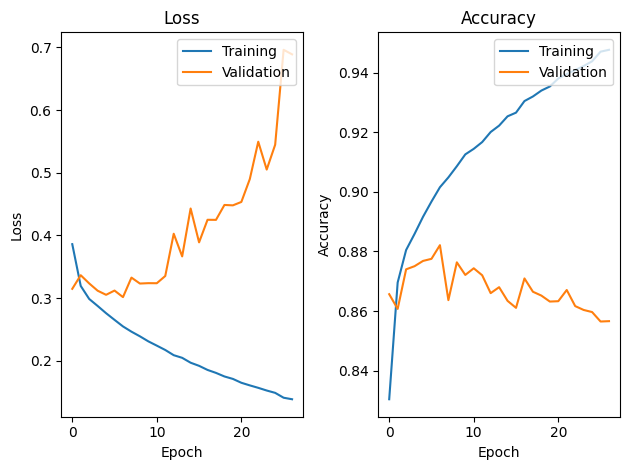

In [116]:
loss_acc_plot(history_custom_embedding_dropout_new)

We see that, although the model still suffers significantly from overfitting, we have managed to improve the predictions with the new dataset. However, I want to make an additional comment. We cannot ignore the fact that the non-paraphrases in this new dataset are quite a bit more different from each other (grammatically, not just semantically) than the paraphrases. Therefore, it's possible that part of the improvement comes from the network learning to differentiate the phrases in that sense rather than in terms of whether they are semantic paraphrases or not.


In [117]:
# Calculate metrics
metrics_custom_embedding_dropout_new = model_custom_embedding_dropout.evaluate(x=[X_test1_new, X_test2_new],
    y=y_test_new)
metrics_custom_embedding_dropout_new

266/266 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.4561 - loss: 0.7104


[0.7094947695732117, 0.4599458873271942]

Finally, we see that the metrics on the test set have improved dramatically.

I believe there are several possibilities for improving this model. First, obtaining more data. I think it’s challenging to obtain pairs of non-paraphrases. I’m sure the approach I’ve taken is not optimal because it introduces very large grammatical differences. However, with a larger dataset of paraphrases and non-paraphrases (even with errors, like the one I generated), we have achieved much better metrics.

Additionally, it might be interesting to optimize some of the network parameters (number of heads in the attention layer, dropout rate, number of neurons in the additional dense layer, etc.). Perhaps it would also be worth exploring what happens if we stack several of these attention-feedforward modules. In this practice, we only introduced one, and it didn’t perform very well. Possibly, with more modules, it could generate deeper representations of the texts' semantics. However, that would need to be accompanied by a much larger dataset to avoid further exacerbating the significant overfitting we’ve observed here.

In [118]:
## 5.2. Hyperparametrization

As a test, I am going to perform hyperparameter tuning on some of these parameters to see if we can achieve better results. I will do this using the new dataset (with the Wikipedia phrases) for training.

In [119]:
import optuna

In [120]:
# Build the models WITHOUT LSTM layer to make training easier

# Fcuntion create_model
def create_model(trial):
    # Hyperparametrization parameters
    units_dense = trial.suggest_int("units_dense", 6, 48)
    dropout_rate_attention = trial.suggest_float("dropout_rate_attention", 0,0.5, step=0.1)
    dropout_rate_dense = trial.suggest_float("dropout_rate_dense", 0.2,0.8, step=0.1)
    num_heads = trial.suggest_int("num_heads", 2, 6, step=2)
    
    input1 = tf.keras.Input(shape=(40,))
    input2 = tf.keras.Input(shape=(40,))

    embedding1 = EmbeddingPosition()(input1)
    embedding2 = EmbeddingPosition()(input2)

    attention1 = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=20)(embedding1, embedding1)
    attention2 = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=20)(embedding2, embedding2)

    dropout1 = tf.keras.layers.Dropout(rate=dropout_rate_attention)(attention1)
    dropout2 = tf.keras.layers.Dropout(rate=dropout_rate_attention)(attention2)

    flatten1 = tf.keras.layers.Flatten()(dropout1)
    flatten2 = tf.keras.layers.Flatten()(dropout2)

    concatenate = tf.keras.layers.Concatenate()([flatten1, flatten2])

    dense = tf.keras.layers.Dense(units=units_dense, activation="relu")(concatenate)

    dropout = tf.keras.layers.Dropout(rate=dropout_rate_dense)(dense)

    output = tf.keras.layers.Dense(1, activation="sigmoid")(dropout)

    model = Model(inputs = [input1, input2], outputs = output)
    
    model.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.BinaryCrossentropy(), metrics=["accuracy"])
    return model

In [121]:
# Goal function
def objective(trial):
    model = create_model(trial)
    patience = trial.suggest_int("patience", 5, 20, step=5)
    
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=patience)
    
    
    history = model.fit(
        x=[X_train1_new, X_train2_new],
        y=y_train_new,
        epochs=100,
        callbacks=[early_stopping],
        shuffle=False,
        validation_data = ([X_val1_new, X_val2_new], y_val_new),
        verbose=0)
    
    min_val_loss = np.min(history.history["val_loss"])
    
    return min_val_loss

In [122]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=25)

[I 2024-12-23 11:19:02,444] A new study created in memory with name: no-name-15505d57-6a0d-478e-99ee-17b31e12f61b
[I 2024-12-23 11:23:40,431] Trial 0 finished with value: 0.3251480758190155 and parameters: {'units_dense': 35, 'dropout_rate_attention': 0.4, 'dropout_rate_dense': 0.8, 'num_heads': 2, 'patience': 20}. Best is trial 0 with value: 0.3251480758190155.
[I 2024-12-23 11:28:17,220] Trial 1 finished with value: 0.29719844460487366 and parameters: {'units_dense': 15, 'dropout_rate_attention': 0.0, 'dropout_rate_dense': 0.2, 'num_heads': 4, 'patience': 20}. Best is trial 1 with value: 0.29719844460487366.
[I 2024-12-23 11:29:41,636] Trial 2 finished with value: 0.3071567118167877 and parameters: {'units_dense': 45, 'dropout_rate_attention': 0.1, 'dropout_rate_dense': 0.4, 'num_heads': 4, 'patience': 5}. Best is trial 1 with value: 0.29719844460487366.
[I 2024-12-23 11:34:40,361] Trial 3 finished with value: 0.3044157326221466 and parameters: {'units_dense': 34, 'dropout_rate_atten

In [123]:
# Best parameters
print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Parameters: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Best trial:
  Value:  0.2959730625152588
  Parameters: 
    units_dense: 7
    dropout_rate_attention: 0.4
    dropout_rate_dense: 0.2
    num_heads: 6
    patience: 15


We have optimal parameters similar to those I used in the previous model. Due to computational time constraints, I only ran 25 trials; it would be interesting to run more to see if the optimal parameters change. Next, I generate and train a model with the optimal parameters.

In [124]:
# Model with the best parameters
input1 = tf.keras.Input(shape=(40,))
input2 = tf.keras.Input(shape=(40,))

embedding1 = EmbeddingPosition()(input1)
embedding2 = EmbeddingPosition()(input2)

attention1 = tf.keras.layers.MultiHeadAttention(num_heads=trial.params["num_heads"], key_dim=20)(embedding1, embedding1)
attention2 = tf.keras.layers.MultiHeadAttention(num_heads=trial.params["num_heads"], key_dim=20)(embedding2, embedding2)

dropout1 = tf.keras.layers.Dropout(rate=trial.params["dropout_rate_attention"])(attention1)
dropout2 = tf.keras.layers.Dropout(rate=trial.params["dropout_rate_attention"])(attention2)

flatten1 = tf.keras.layers.Flatten()(dropout1)
flatten2 = tf.keras.layers.Flatten()(dropout2)

concatenate = tf.keras.layers.Concatenate()([flatten1, flatten2])

dense = tf.keras.layers.Dense(units=trial.params["units_dense"], activation="relu")(concatenate)

dropout = tf.keras.layers.Dropout(rate=trial.params["dropout_rate_dense"])(dense)

output = tf.keras.layers.Dense(1, activation="sigmoid")(dropout)

model_optimized = Model(inputs = [input1, input2], outputs = output)
    
model_optimized.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.BinaryCrossentropy(), metrics=["accuracy"])
model_optimized.summary()

Model: "functional_59"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_58      │ (None, 40)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_59      │ (None, 40)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_position… │ (None, 40, 40)    │    100,000 │ input_layer_58[0… │
│ (EmbeddingPosition) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_position… │ (None, 40, 40)    │    100,000 │ input_layer_59[0… │
│ (EmbeddingPosition) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 40, 40)    │     19,600 │ embedding_positi… │
│ (MultiHeadAttentio… │                   │            │ embedding_positi… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 40, 40)    │     19,600 │ embedding_positi… │
│ (MultiHeadAttentio… │                   │            │ embedding_positi… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_141         │ (None, 40, 40)    │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_142         │ (None, 40, 40)    │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_58          │ (None, 1600)      │          0 │ dropout_141[0][0] │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_59          │ (None, 1600)      │          0 │ dropout_142[0][0] │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_315     │ (None, 3200)      │          0 │ flatten_58[0][0], │
│ (Concatenate)       │                   │            │ flatten_59[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_56 (Dense)    │ (None, 7)         │     22,407 │ concatenate_315[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_143         │ (None, 7)         │          0 │ dense_56[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_57 (Dense)    │ (None, 1)         │          8 │ dropout_143[0][0] │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 261,615 (1021.93 KB)

 Trainable params: 261,615 (1021.93 KB)

 Non-trainable params: 0 (0.00 B)

In [125]:
start = time.time()
# Training
    
early_stopping_optimized = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=trial.params["patience"])
    
    
history_model_optimized = model_optimized.fit(
    x=[X_train1_new, X_train2_new],
    y=y_train_new,
    epochs=100,
    callbacks=[early_stopping_optimized],
    shuffle=False,
    validation_data = ([X_val1_new, X_val2_new], y_val_new))


print("Training time: "+str(time.time()-start)+" seconds")

Epoch 1/100
4782/4782 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step - accuracy: 0.7955 - loss: 0.4393 - val_accuracy: 0.8511 - val_loss: 0.3538
Epoch 2/100
4782/4782 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.8587 - loss: 0.3490 - val_accuracy: 0.8596 - val_loss: 0.3325
Epoch 3/100
4782/4782 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.8703 - loss: 0.3254 - val_accuracy: 0.8642 - val_loss: 0.3246
Epoch 4/100
4782/4782 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.8767 - loss: 0.3146 - val_accuracy: 0.8658 - val_loss: 0.3205
Epoch 5/100
4782/4782 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.8808 - loss: 0.3032 - val_accuracy: 0.8679 - val_loss: 0.3223
Epoch 6/100
4782/4782 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.8873 - loss: 0.2917 - val_accuracy: 0.8620 - val_loss: 0.3300
Epoch 7/100
4782/4782 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.8908 - loss: 0.2818 - val_accuracy: 0.8593 - val_loss: 0.3408
Epoch 8/100
4782/4782 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.8930 -

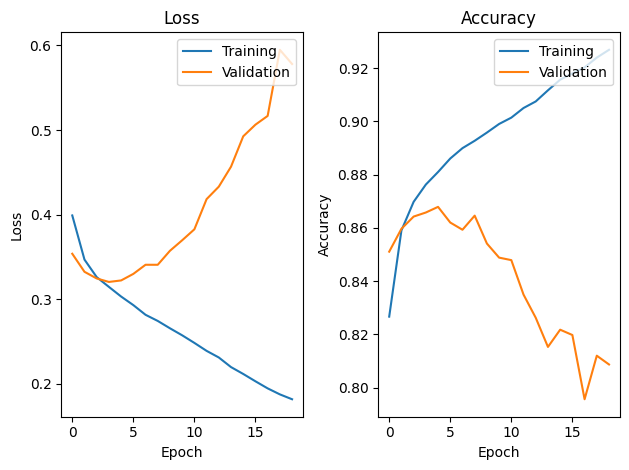

In [126]:
loss_acc_plot(history_model_optimized)

In [127]:
# Calculate metrics
metrics_model_optimized = model_optimized.evaluate(x=[X_test1_new, X_test2_new],
    y=y_test_new)
metrics_model_optimized

266/266 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8145 - loss: 0.5806


[0.5577548742294312, 0.8129631876945496]

Finally, we see that we have managed to slightly improve the model's accuracy, although we still have overfitting issues. I think it's important to emphasize again that the quality of the paraphrases and (especially) the non-paraphrases generated is not ideal. I understand that the main challenge in this task is obtaining a dataset that is both sufficiently good and sufficiently large to ensure that the network is learning what we want it to learn (rather than spurious features of the data) and does not overfit.